# Human Protein Atlas Image Classification
- 数据分布高度不平衡，自定义focal loss
- 使用了大量数据分析功能
- 多目标分类，迁移学习，训练采用k折交叉验证
- 使用macro F1 score作为精度标准
- 存取ckeckpoint文件

### 1.导入所需库

In [1]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imread

import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2

os.listdir('.')

['.ipynb_checkpoints',
 'checkpoint',
 'HPA_dataset.py',
 'HPA_run.ipynb',
 'model_and_loss.py',
 'mysub.csv',
 'originaldata',
 'test',
 'train',
 'train_and_test.py',
 'weights.pt',
 '__pycache__']

### 2.利用pandas查看labels

In [2]:
labels_pd = pd.read_csv('./originaldata/train.csv', sep=',', header=0)
print(labels_pd.shape)
labels_pd.head()

(31072, 2)


,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [3]:
classes_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"    
}

reverse_classes_names = {v:k for k,v in classes_names.items()}

#### 添加以蛋白质种类为标签的各列，以0填充，然后将每行的Target所对应的蛋白质种类置1

In [4]:
def fill_targets(row):
    row.Target = row.Target.split(' ')
    for i in row.Target:
        row[classes_names[int(i)]] = 1
    return row

for i in classes_names.values():   # 以0填充各列
    labels_pd[i] = 0
    
labels_pd = labels_pd.apply(fill_targets, axis=1)  # 置1
labels_pd.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


#### 显示每个标签出现的次数

In [ ]:
classes_counts = labels_pd.drop(['Id', 'Target'], axis=1).sum(axis='index').sort_values(ascending=False)
fig1 = plt.figure(figsize=(10,6))
sns.barplot(y=classes_counts.index, x=classes_counts.values)

#### 显示每个样本包含的标签数量分布

In [ ]:
num_targets_per_sample = labels_pd.drop(['Id', 'Target'], axis=1).sum(axis=1)
num_target_counts = num_targets_per_sample.value_counts()
num_traget_per = num_target_counts / num_targets_per_sample.shape[0] * 100.0
fig2 = plt.figure(figsize=(10, 3))
plt.xlabel('Num of Targets per Image')
plt.ylabel('Percentage of Dataset')
sns.barplot(num_traget_per.index, num_traget_per.values, palette='Blues')

#### 显示各类同时出现的关系热力图

In [ ]:
fig3 = plt.figure(figsize=(8,6)) 
sns.heatmap(labels_pd[num_targets_per_sample>1].drop(['Id','Target'], axis=1).corr(),
            vmin=-1, vmax=1, cmap='RdYlBu')

#### 显示关系较大的几组类别
#### Lysosomes and endosomes

In [ ]:
def find_counts(target, label_frame):
    target_frame = label_frame[label_frame[target] == 1].drop(['Id','Target'], axis='columns')
    target_counts = target_frame.sum(axis=0)
    target_counts = target_counts[target_counts>0]
    target_counts = target_counts.sort_values(ascending=False)
    return target_counts

In [ ]:
Lysosomes_counts = find_counts('Lysosomes', labels_pd)
print(Lysosomes_counts)
fig4 = plt.figure(figsize=(6,3))
sns.barplot(Lysosomes_counts.index, Lysosomes_counts.values, palette='Reds_r')
# 结果说明 Lysosomes和 Endosomes总是同时出现，完全相关

#### Rods and rings

In [ ]:
Rods_rings_counts = find_counts('Rods & rings', labels_pd)
fig5 = plt.figure(figsize=(12,3))
sns.barplot(Rods_rings_counts.index, Rods_rings_counts.values, palette='Greens_r')

#### Microtubule ends

In [ ]:
Microtubule_ends_counts = find_counts('Microtubule ends', labels_pd)
fig6 = plt.figure(figsize=(9,3))
sns.barplot(Microtubule_ends_counts.index, Microtubule_ends_counts.values, palette='Blues_r')

#### Peroxisomes

In [ ]:
Peroxisomes_counts = find_counts('Peroxisomes', labels_pd)
fig7 = plt.figure(figsize=(12,3))
sns.barplot(Peroxisomes_counts.index, Peroxisomes_counts.values, palette='Purples_r')

#### Cytokinetic bridge

In [ ]:
Cytokinetic_bridge_counts = find_counts('Cytokinetic bridge', labels_pd)
fig8 = plt.figure(figsize=(15,3))
sns.barplot(Cytokinetic_bridge_counts.index, Cytokinetic_bridge_counts.values, palette='Oranges_r')
plt.xticks(rotation=70)

### 3. 查看数据集图像

In [ ]:
files = os.listdir('./train')
for i in files[:10]:
    print(i)
    
print(len(files)/4)

In [ ]:
def show_whole_img(idx, label_frame, path='./train'):
    img_id = label_frame.loc[idx].Id
    path_prefix = os.path.join(path, img_id)
    path_suffix = ['_blue.png', '_green.png', '_red.png', '_yellow.png']
    labels = label_frame.loc[idx].Target
    title = '+'.join([classes_names[int(label)] for label in labels])
    img = np.zeros((512, 512, 4))
    for i in range(4):
        img[:,:,i] = plt.imread(path_prefix+path_suffix[i])
    _, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,True,True,figsize=(15,5))
    ax1.imshow(img[:,:,0], cmap='Blues')
    ax1.set_title('stained nucleus')
    ax2.imshow(img[:,:,1], cmap='Greens')
    ax2.set_title(title)
    ax3.imshow(img[:,:,2], cmap='Reds')
    ax3.set_title('stained microtubules')
    ax4.imshow(img[:,:,3], cmap='Oranges')
    ax4.set_title('stained endoplasmatic reticulum')
    return img_id, img
    
imgpick_id, imgpick = show_whole_img(100, labels_pd)
print(f'Id is {imgpick_id}')
figy = plt.figure(figsize=(4,5))
plt.imshow(imgpick)  # 直接显示img0, 会mask掉第0层，即blue层

### 4.定义、加载数据集
- 利用k折交叉验证

#### 预定义一些Hyperparameters

In [5]:
# ----------------------------------------------------------------------------------------------------------------
N_Splits = 3
N_Repeats = 3
BS = 128
NUM_Workers = 0
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
PATH_Train = './train'
PATH_Test = './test'
PATH_Ckp = './checkpoint'
FILENAME_Sub = './mysub.csv'
WEIGHT = (1.0/(torch.from_numpy(labels_pd[labels_pd.columns[2:]].sum(axis=0).values.astype(np.float32)))).pow_(0.5)
GAMMA = 2  # focusing parameter for focal loss
LR = 0.001
WEIGHT_Decay = 0.0005
MOMENTUM =0.9
EPOCH = 50
EPOCH_Saveckp = 25
# ----------------------------------------------------------------------------------------------------------------

#### a. 设置k折和重复次数

In [6]:
print(f"Percentage of test / train: \
      {len(os.listdir('./test'))/len(os.listdir('./train'))*100:2.1f}%")

# 由于测试集大小为训练集的约1/3，故选择 k=3
from sklearn.model_selection import RepeatedKFold
splitter = RepeatedKFold(n_splits=N_Splits, n_repeats=N_Repeats, random_state=None)

Percentage of test / train:       37.7%


In [7]:
patitions = []
for train, val in splitter.split(labels_pd.index.values):
    patition = {'train': train, 
                'val': val}
    patitions.append(patition)
    
    print(f'Train: {train}, Val: {val}')
    print(f'Train: {len(train)}, Val: {len(val)}')

# print(patitions[0]['train'][:5])

Train: [    0     1     2 ... 31068 31069 31070], Val: [    4     6     8 ... 31058 31059 31071]
Train: 20714, Val: 10358
Train: [    1     2     4 ... 31067 31070 31071], Val: [    0     3     5 ... 31066 31068 31069]
Train: 20715, Val: 10357
Train: [    0     3     4 ... 31068 31069 31071], Val: [    1     2     7 ... 31064 31067 31070]
Train: 20715, Val: 10357
Train: [    0     2     3 ... 31067 31068 31070], Val: [    1     5    19 ... 31058 31069 31071]
Train: 20714, Val: 10358
Train: [    1     2     3 ... 31068 31069 31071], Val: [    0     4     6 ... 31064 31066 31070]
Train: 20715, Val: 10357
Train: [    0     1     4 ... 31069 31070 31071], Val: [    2     3     8 ... 31065 31067 31068]
Train: 20715, Val: 10357
Train: [    0     1     3 ... 31068 31069 31071], Val: [    2     6     9 ... 31064 31067 31070]
Train: 20714, Val: 10358
Train: [    1     2     3 ... 31068 31069 31070], Val: [    0     5     8 ... 31065 31066 31071]
Train: 20715, Val: 10357
Train: [    0     2     

#### b.读入训练和测试数据集，按照k折和重复次数划分数据集

In [8]:
from HPA_dataset import *

TRANS = transforms.Compose([
    Scale(256),
    RandomColor(0.1,0.2,0.1,0.1),
    RandomRotate(10),
    RandomCrop(224),
    totensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.406],
                         std=[0.229, 0.224, 0.225, 0.225])])

# ------------------------train and val set-----------------------------
HPA_total_train = HPAdata_train(labels_pd, PATH_Train, transform=TRANS)

trainsets = []
valsets = []
for patition in patitions:
    train = Subset(HPA_total_train, patition['train'])
    val = Subset(HPA_total_train, patition['val'])
    trainsets.append(train)
    valsets.append(val)

trainloaders = []
valloaders = []
for i in range(len(trainsets)):
    trainloader = DataLoader(trainsets[i], batch_size=BS, shuffle=True, num_workers=NUM_Workers)
    valloader = DataLoader(valsets[i], batch_size=BS, shuffle=True, num_workers=NUM_Workers)
    trainloaders.append(trainloader)
    valloaders.append(valloader)
    
print(len(trainloaders))
print(len(trainloaders[1]))

# ------------------------test set-----------------------------
testset = HPAdata_test(PATH_Test, transform=TRANS)
testloader = DataLoader(testset, shuffle=False, batch_size=BS, num_workers=NUM_Workers)

print(len(testset))
print(len(testloader))

9
162
11702
92


#### c. 加载CNN模型和自定义损失函数
- Resnet19的迁移学习, 所有参数均参与训练
- Focal loss
- 设置optimizer和scheduler

In [9]:
from model_and_loss import *

model = HPA_Res18()
criterion = FocalLoss_Plus(gamma=GAMMA, weight=WEIGHT)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_Decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

#### d. 训练并记录loss和acc等
- 共训练 3*3次
- 每次epoch=50

In [10]:
from train_and_test import *

Loop 1/2 processing...
epoch 1... done
epoch 2... done
saving checkpoint-loop1_epoch2... done
Loop 1/2 finished! Time used: 28.8s
loss: 0.08, acc: 0.200
------------------------------
Loop 2/2 processing...
epoch 1... done
epoch 2... done
saving checkpoint-loop2_epoch2... done
Loop 2/2 finished! Time used: 28.4s
loss: 0.06, acc: 0.200
------------------------------
Total time used: 57.7s


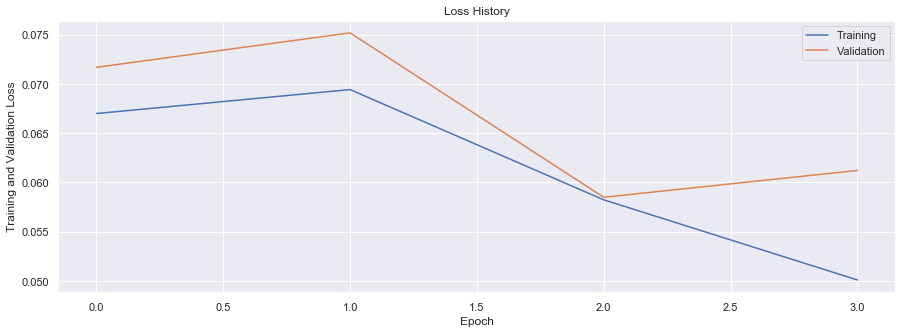

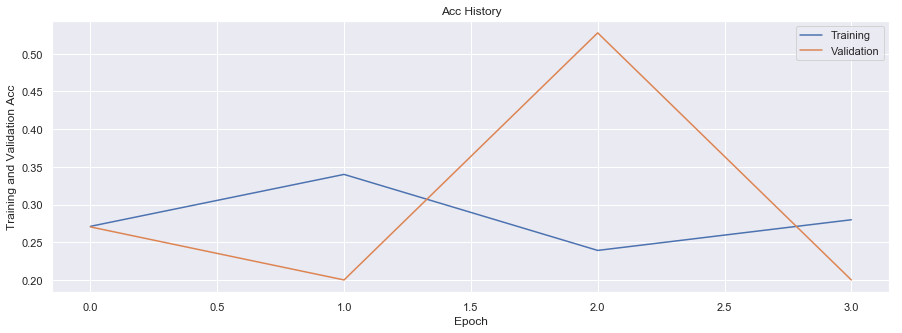

In [11]:
# this block is to define a small subset for testing if train_model could be normaly implemented.
train_try = [Subset(HPA_total_train, range(20)), Subset(HPA_total_train, range(20, 40))]
val_try = [Subset(HPA_total_train, range(40,50)), Subset(HPA_total_train, range(50, 60))]
trainloader_try = [DataLoader(train_try[0], batch_size=4, shuffle=True, num_workers=NUM_Workers), 
                   DataLoader(train_try[1], batch_size=4, shuffle=True, num_workers=NUM_Workers)]
valloader_try = [DataLoader(val_try[0], batch_size=4, shuffle=True, num_workers=NUM_Workers), 
                 DataLoader(val_try[1], batch_size=4, shuffle=True, num_workers=NUM_Workers)]

History = train_model(trainloader = trainloader_try, 
                      valloader = valloader_try, 
                      model = model, 
                      optimizer = optimizer, 
                      criterion = criterion, 
                      scheduler = scheduler, 
                      epochs=2, device=DEVICE, history=Epoch_History(), ckp_path=PATH_Ckp, ckp_savestep=2)

History.plot_history()

In [ ]:
# training the whole dataset
# History = train_model(trainloader = trainloaders, 
#                       valloader = valloaders, 
#                       model = model, 
#                       optimizer = optimizer, 
#                       criterion = criterion, 
#                       scheduler = scheduler, 
#                       epochs=EPOCH, device=DEVICE, history=Epoch_History(), ckp_path=PATH_Ckp, ckp_savestep=EPOCH_Saveckp)

# History.plot_history()

#### e. 测试并保存csv文件

In [12]:
# this block is to test a small subset of testset, checking test_model function
testset_try = Subset(testset, range(20))
testloader_try = DataLoader(testset_try, batch_size=2, shuffle=False, num_workers=NUM_Workers)

model = HPA_Res18()
model.load_state_dict(torch.load('./weights.pt'))
results_dict = test_model(testloader_try, model, device=DEVICE, results_filename=FILENAME_Sub)

Testing ...
25% done ...
50% done ...
75% done ...
Test Finished! Time used: 7.4s


In [ ]:
# model = HPA_Res18()
# model = model.load_state_dict(torch.load('./weights.pt'))
# results_dict = test_model(testloader, model, device=DEVICE, results_filename=FILENAME_Sub)

## 以下为一些练习和测试代码，可删

In [ ]:
os.path.exists('./checkpoint')

In [ ]:
a = [1,2,3,4,5,6,7]
a[::2]

In [ ]:
result_dict = {'id':(1,2,3,4),'labels':[3,4,5,6]}
result_df = pd.DataFrame(result_dict)
result_df.to_csv('./try.csv', index=False)
result_df

In [ ]:
a = next(iter(testloader))

In [ ]:
a[0]

In [ ]:
def gen_results(input):
    preds = (input>0.5).to(torch.int32)
    preds_labels = [[j for j in range(preds.shape[1]) if preds[i,j]==1] for i in range(preds.shape[0])]
    labels = [' '.join(map(lambda x: str(x), i)) for i in preds_labels]
    return labels

In [ ]:
try_tensor = torch.rand((10,3))
print(try_tensor)
labels_try  = gen_results(try_tensor)
print(labels_try)

In [ ]:
o = next(iter(testloader_try))
oo = model(o[1])

In [ ]:
oo

In [ ]:
gen_results(oo)